In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
from pprint import pprint
import matplotlib.pyplot as plt
import json
import tiktoken
from tqdm import tqdm

### Open the JSON file with the collected data

In [2]:
file_path = 'simple-scraped-kernels.json'

# Open and load the JSON file
with open(file_path, 'r') as file:
    data = json.load(file)

### Let's create a dataframe to store the stats of each kernel

In [3]:
df = pd.DataFrame()
enc = tiktoken.encoding_for_model("gpt-4o-mini")

In [4]:

for target in tqdm(data, desc='Counting tokens'):
    basename = target['basename']
    kernelNames = target['kernelNames']
    for kern in kernelNames:
        statsDict = {'target':[basename], 'kernelName': [kern]}
        kernCtx = target['kernels'][kern]
        #print(kernCtx)
        encoded = enc.encode(kernCtx)
        statsDict['numTokens'] = [len(encoded)]

        kernDF = pd.DataFrame.from_dict(statsDict).astype({'target': str, 'kernelName': str, 'numTokens': int})
        df = pd.concat([df, kernDF], ignore_index=True)




Counting tokens: 100%|██████████| 750/750 [00:28<00:00, 26.03it/s] 


In [5]:
# let's check our dataframe
print(df.shape)
print(df.head(10))

cudaDF = df[df['target'].str.contains('-cuda')]
cudaDF = cudaDF.sort_values(by=['numTokens'], ascending=True, ignore_index=True)

ompDF = df[df['target'].str.contains('-omp')]
ompDF = ompDF.sort_values(by=['numTokens'], ascending=True, ignore_index=True)

# this is cost in USD
costPer1e6Tokens = 0.15

# add some stats to the dataset
cudaDF['totalSumTokens'] = cudaDF['numTokens'].cumsum()
cudaDF['totalInfCost'] = costPer1e6Tokens*(cudaDF['totalSumTokens']/1e6)

ompDF['totalSumTokens'] = ompDF['numTokens'].cumsum()
ompDF['totalInfCost'] = costPer1e6Tokens*(ompDF['totalSumTokens']/1e6)

print(cudaDF.shape)
print(cudaDF.head(10))
print()
print()
print(ompDF.shape)
print(ompDF.head(10))

(2242, 3)
          target                                         kernelName  numTokens
0  accuracy-cuda                                    accuracy_kernel       1154
1   accuracy-omp            __omp_offloading_10309_2f04138_main_l57        764
2       ace-cuda                                          allenCahn       7879
3       ace-cuda                                    thermalEquation       7879
4       ace-cuda                                     calculateForce       7879
5       ace-cuda                                           swapGrid       7879
6       ace-cuda                                boundaryConditionsU       7879
7       ace-cuda                              boundaryConditionsPhi       7879
8        ace-omp  __omp_offloading_10309_2f0414b__Z8swapGridPA40...       4458
9        ace-omp  __omp_offloading_10309_2f0414b__Z21boundaryCon...       4458
(1222, 5)
                 target              kernelName  numTokens  totalSumTokens  \
0          reverse-cuda          

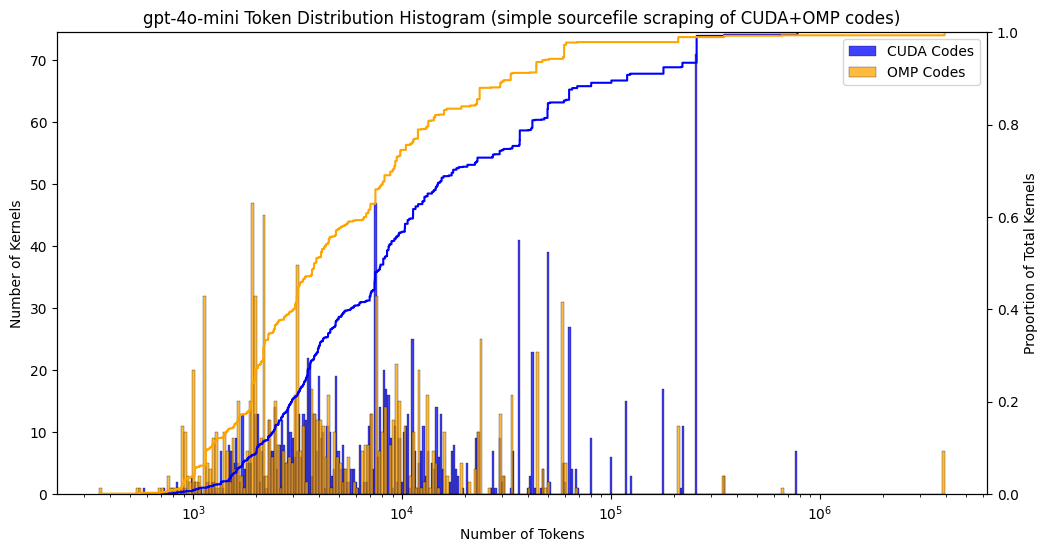

In [6]:

fig, ax = plt.subplots(1, figsize=(12,6))


sns.histplot(cudaDF, x='numTokens', bins=300, ax=ax, log_scale=True, color='blue')
sns.histplot(ompDF, x='numTokens', bins=300, ax=ax, log_scale=True, color='orange')
ax2 = ax.twinx()
sns.ecdfplot(cudaDF, x='numTokens', ax=ax2, log_scale=True, color='blue')
sns.ecdfplot(ompDF, x='numTokens', ax=ax2, log_scale=True, color='orange')

ax.set_xlabel('Number of Tokens')
ax.set_ylabel('Number of Kernels')
ax2.set_ylabel('Proportion of Total Kernels')

ax.legend(['CUDA Codes', 'OMP Codes'])

ax.set_title('gpt-4o-mini Token Distribution Histogram (simple sourcefile scraping of CUDA+OMP codes)')

plt.show()


### Expected Cost Analysis

In [7]:
# sort the dataframe by token count


In [8]:

# given a sorted dataframe
def getNumTokensCDF(df, percent):
    numRows = df.shape[0]
    # map the percent to the numRows range
    idx = int(percent * (numRows-1))
    numTokens = df.iloc[idx]['numTokens']
    return numTokens

def getNumSamplesLTETokenCount(df, tokCount):
    subset = df[df['numTokens'] <= tokCount]
    return subset.shape[0]

In [9]:
percents = [0.1, 0.25, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0]

for perc in percents:
    print(f'  CUDA {int(100*perc)}% of samples have token count <= {getNumTokensCDF(cudaDF, perc)} tokens ({getNumSamplesLTETokenCount(cudaDF, getNumTokensCDF(cudaDF, perc))} samples)')
    print(f'OPENMP {int(100*perc)}% of samples have token count <= {getNumTokensCDF(ompDF, perc)} tokens ({getNumSamplesLTETokenCount(ompDF, getNumTokensCDF(ompDF, perc))} samples)')
    print()

print(f'  CUDA Num samples with less than 25k tokens: {getNumSamplesLTETokenCount(cudaDF, 25000)}')
print(f'OPENMP Num samples with less than 25k tokens: {getNumSamplesLTETokenCount(ompDF, 25000)}')

  CUDA 10% of samples have token count <= 2023 tokens (123 samples)
OPENMP 10% of samples have token count <= 1202 tokens (102 samples)

  CUDA 25% of samples have token count <= 3473 tokens (307 samples)
OPENMP 25% of samples have token count <= 1971 tokens (255 samples)

  CUDA 50% of samples have token count <= 8125 tokens (623 samples)
OPENMP 50% of samples have token count <= 3797 tokens (510 samples)

  CUDA 60% of samples have token count <= 11270 tokens (733 samples)
OPENMP 60% of samples have token count <= 6570 tokens (612 samples)

  CUDA 65% of samples have token count <= 13250 tokens (795 samples)
OPENMP 65% of samples have token count <= 7452 tokens (673 samples)

  CUDA 70% of samples have token count <= 17562 tokens (858 samples)
OPENMP 70% of samples have token count <= 9007 tokens (716 samples)

  CUDA 75% of samples have token count <= 33770 tokens (921 samples)
OPENMP 75% of samples have token count <= 10423 tokens (771 samples)

  CUDA 80% of samples have token cou

In [10]:

def calcMinCostOfInferenceForPercentOfDF(df, percent):
    numRows = df.shape[0]
    # map the percent to the numRows range
    idx = int(percent * (numRows-1))

    subset = df.iloc[0:idx+1]

    totalNumTokens = subset['numTokens'].sum()

    cost = costPer1e6Tokens * (totalNumTokens/1e6)

    return cost
    


In [11]:

for perc in percents:
    print(f'  CUDA Min expected cost to inference smallest {int(100*perc)}% of dataset: ${round(calcMinCostOfInferenceForPercentOfDF(cudaDF, perc),4)}')
    print(f'OPENMP Min expected cost to inference smallest {int(100*perc)}% of dataset: ${round(calcMinCostOfInferenceForPercentOfDF(ompDF, perc),4)}')
    print()

  CUDA Min expected cost to inference smallest 10% of dataset: $0.0289
OPENMP Min expected cost to inference smallest 10% of dataset: $0.0154

  CUDA Min expected cost to inference smallest 25% of dataset: $0.1047
OPENMP Min expected cost to inference smallest 25% of dataset: $0.0541

  CUDA Min expected cost to inference smallest 50% of dataset: $0.3519
OPENMP Min expected cost to inference smallest 50% of dataset: $0.1583

  CUDA Min expected cost to inference smallest 60% of dataset: $0.5229
OPENMP Min expected cost to inference smallest 60% of dataset: $0.23

  CUDA Min expected cost to inference smallest 65% of dataset: $0.6333
OPENMP Min expected cost to inference smallest 65% of dataset: $0.2847

  CUDA Min expected cost to inference smallest 70% of dataset: $0.774
OPENMP Min expected cost to inference smallest 70% of dataset: $0.3466

  CUDA Min expected cost to inference smallest 75% of dataset: $0.9984
OPENMP Min expected cost to inference smallest 75% of dataset: $0.4196

  

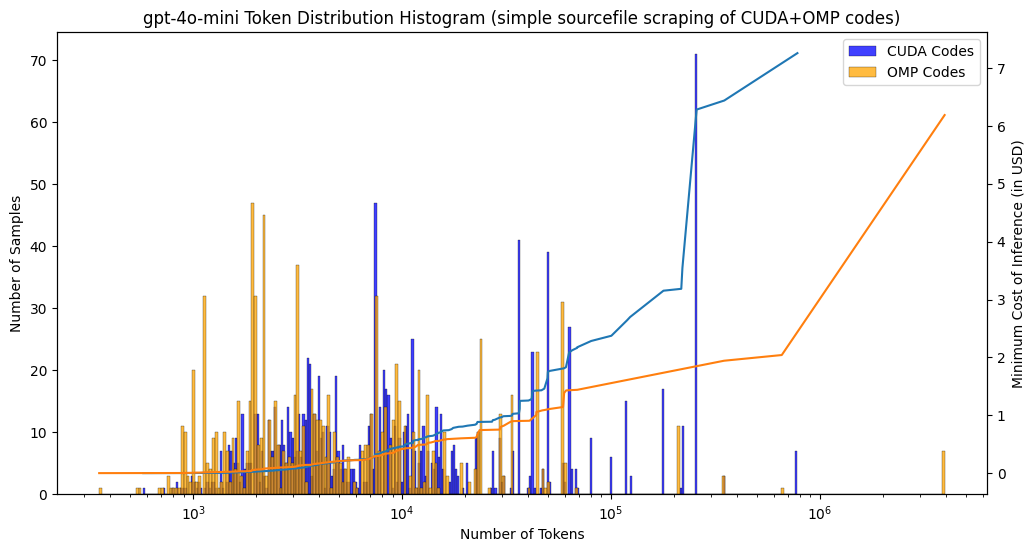

In [12]:
fig, ax = plt.subplots(1, figsize=(12,6))

sns.histplot(cudaDF, x='numTokens', bins=300, ax=ax, log_scale=True, color='blue')
sns.histplot(ompDF, x='numTokens', bins=300, ax=ax, log_scale=True, color='orange')
ax2 = ax.twinx()
sns.lineplot(cudaDF.groupby(['numTokens'])['totalInfCost'].max().reset_index().sort_values(by=['numTokens'], ascending=True, ignore_index=True), x='numTokens', y='totalInfCost', ax=ax2)
sns.lineplot(ompDF.groupby(['numTokens'])['totalInfCost'].max().reset_index().sort_values(by=['numTokens'], ascending=True, ignore_index=True), x='numTokens', y='totalInfCost', ax=ax2)

ax.set_xlabel('Number of Tokens')
ax.set_ylabel('Number of Samples')
ax2.set_ylabel('Minimum Cost of Inference (in USD)')

ax.legend(['CUDA Codes', 'OMP Codes'])

ax.set_title('gpt-4o-mini Token Distribution Histogram (simple sourcefile scraping of CUDA+OMP codes)')

plt.show()

### Pruning the Dataset

In [13]:
def savePercentOfDF(df, percent, outfile):
    numRows = df.shape[0]
    # map the percent to the numRows range
    idx = int(percent * (numRows-1))

    subset = df.iloc[0:idx+1]

    targetNames = list(subset['target'].unique())

    subset = df[df['target'].isin(targetNames)]

    tosave = []

    for target in tqdm(data, desc='Gathering targets to export'):
        basename = target['basename']
        if basename in targetNames:
            tosave.append(target)

    with open(outfile, 'w') as fp:
        json.dump(tosave, fp, indent=4)

    print(f'Expected min inference cost: ${round(subset.iloc[subset.shape[0]-1]["totalInfCost"], 3)} for {outfile}')
    print(f'Num kernels: {subset.shape[0]} for {outfile}')
    print()


def saveMaxTokenCountOfDF(df, maxTokens, outfile):
    subset = df[df['numTokens'] <= maxTokens]

    targetNames = list(subset['target'].unique())

    subset = df[df['target'].isin(targetNames)]

    tosave = []

    for target in data:
        basename = target['basename']
        if basename in targetNames:
            tosave.append(target)

    with open(outfile, 'w') as fp:
        json.dump(tosave, fp, indent=4)

    print(f'Expected min inference cost: ${round(subset.iloc[subset.shape[0]-1]["totalInfCost"], 3)} for {outfile}')
    print(f'Num kernels: {subset.shape[0]} for {outfile}')
    print()




In [14]:
#savePercentOfDF(cudaDF, 0.65, 'simple-scraped-kernels-CUDA-pruned.json')
#savePercentOfDF(ompDF, 0.65, 'simple-scraped-kernels-OMP-pruned.json')

saveMaxTokenCountOfDF(cudaDF, 7452, 'simple-scraped-kernels-CUDA-pruned.json')
saveMaxTokenCountOfDF(ompDF, 7452, 'simple-scraped-kernels-OMP-pruned.json')

Expected min inference cost: $0.324 for simple-scraped-kernels-CUDA-pruned.json
Num kernels: 587 for simple-scraped-kernels-CUDA-pruned.json

Expected min inference cost: $0.296 for simple-scraped-kernels-OMP-pruned.json
Num kernels: 673 for simple-scraped-kernels-OMP-pruned.json



In [15]:
saveMaxTokenCountOfDF(cudaDF, 8e3, 'simple-scraped-kernels-CUDA-pruned.json')
saveMaxTokenCountOfDF(ompDF, 8e3, 'simple-scraped-kernels-OMP-pruned.json')

Expected min inference cost: $0.347 for simple-scraped-kernels-CUDA-pruned.json
Num kernels: 607 for simple-scraped-kernels-CUDA-pruned.json

Expected min inference cost: $0.309 for simple-scraped-kernels-OMP-pruned.json
Num kernels: 684 for simple-scraped-kernels-OMP-pruned.json

